In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/micro_data.zip -d /content

# Loading and visualizing the data

In [1]:
import numpy as np
from glob import glob
from torch.utils.data import random_split, DataLoader, Dataset

class MicroDataset(Dataset):
  def __init__(self):
    self.files = glob("/content/micro_data/**/*_seg.npz", recursive=True)

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    seg = np.load(self.files[idx])
    im_mic = seg["im_mic"]
    im_markers = seg["im_markers"]
    return im_mic, im_markers

dataset = MicroDataset()
train_size = int(0.98*len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

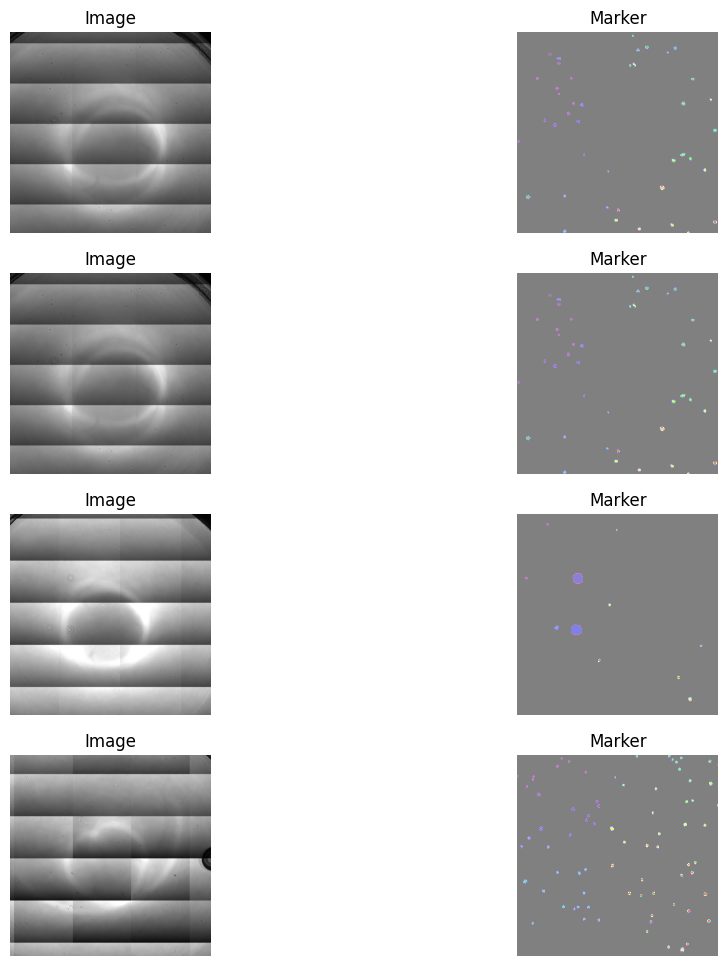

In [5]:
import matplotlib.pyplot as plt

NUM_EXAMPLES = 4
ids = np.random.randint(0, len(dataset) + 1, size=NUM_EXAMPLES)

fig, ax = plt.subplots(nrows=NUM_EXAMPLES, ncols=2, figsize=(12, 12))
for i in range(NUM_EXAMPLES):
  mic, markers = dataset[ids[i]]
  ax[i][0].set_title("Image")
  ax[i][0].imshow(mic)
  ax[i][0].axis('off')
  ax[i][1].set_title("Marker")
  ax[i][1].imshow(markers, cmap=plt.cm.nipy_spectral, alpha=0.5)
  ax[i][1].axis('off')

# Training the cellpose model with our data

In [ ]:
%pip install cellpose
%pip install tifffile

In [4]:
import os
import tifffile

"""
Our dataset is too big for cellpose to train in one iteration because
it reads the whole dataset into memory.
For this purpose we are doing the training in iterations.
"""

train_iterations = 20
train_dir = "/content/train"
test_dir = "/content/test"

def create_cellpose_dataset(dataset, dir, iterations):
  if not os.path.exists(dir):
    os.mkdir(dir)
  boundaries = np.linspace(start=0, stop=(len(dataset)), num=iterations+1)
  for i in range(1, len(boundaries)):
    start, end = int(boundaries[i-1]), int(boundaries[i])
    iteration_dir = os.path.join(dir, str(i))
    if not os.path.exists(iteration_dir):
      os.mkdir(iteration_dir)
    save_cellpose_iteration(dataset, iteration_dir, start, end)

def save_cellpose_iteration(dataset, dir, start, end):
  for i in range(start, end):
    img, masks = dataset[i]
    tifffile.imwrite(os.path.join(dir, f"{i}.tif"), img)
    tifffile.imwrite(os.path.join(dir, f"{i}_masks.tif"), masks)

create_cellpose_dataset(train_dataset, train_dir, train_iterations)
create_cellpose_dataset(test_dataset, test_dir, 1)

In [5]:
from cellpose import io, models, train, core

n_epochs =  100
initial_model = "cyto3"
model_name = "segmentation_model"
learning_rate = 0.1
weight_decay = 0.0001
channels = [0, 0]

logger = io.logger_setup()

use_GPU = core.use_gpu()
print(use_GPU)
model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

def train_iteration(iteration):
  output = io.load_train_test_data(
      os.path.join(train_dir, str(iteration)),
      os.path.join(test_dir, "1"))
  train_data, train_labels, _, test_data, test_labels, _ = output
  return train.train_seg(model.net, train_data=train_data,
                              train_labels=train_labels,
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=channels,
                              save_path=train_dir,
                              n_epochs=n_epochs,
                              learning_rate=learning_rate,
                              weight_decay=weight_decay,
                              SGD=True,
                              nimg_per_epoch=8,
                              model_name=model_name)

for i in range(1, train_iterations+1):
  train_iteration(i)

True


100%|██████████| 4/4 [00:00<00:00, 12.71it/s]


# Predicting with our fine-tuned model

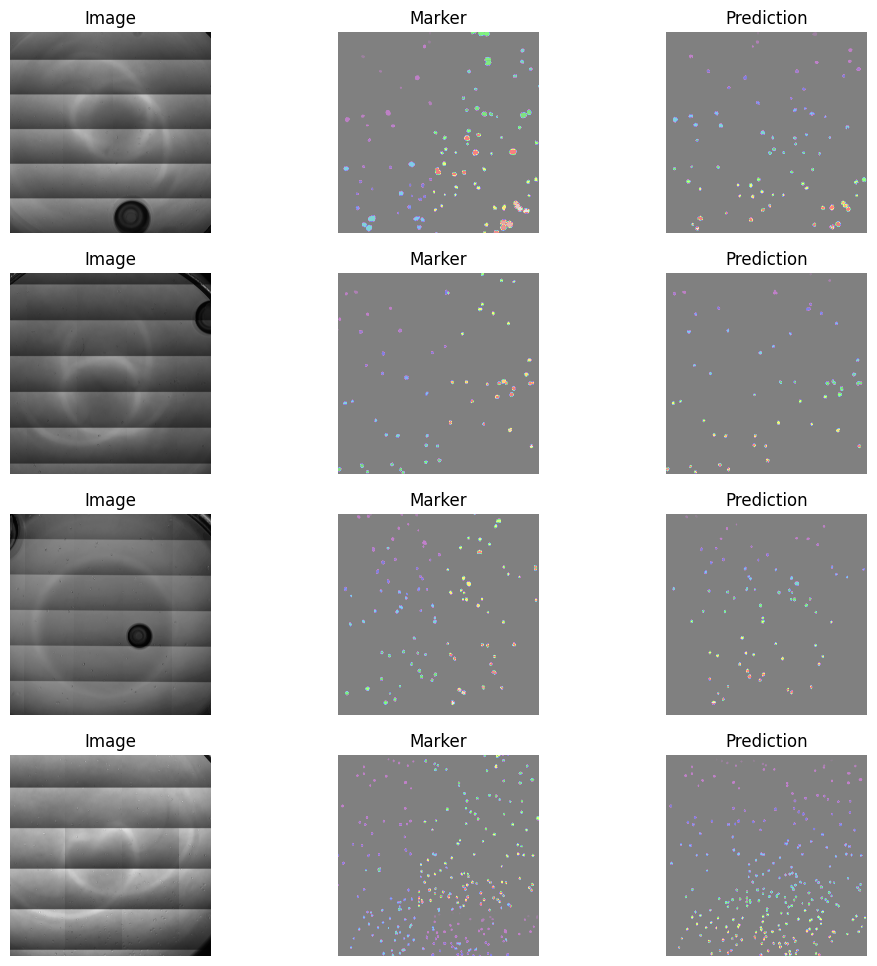

In [14]:
import matplotlib.pyplot as plt

model = models.CellposeModel(gpu=True,
                             pretrained_model="/content/train/models/segmentation_model")

NUM_EXAMPLES = 4
ids = np.random.randint(0, len(dataset) + 1, size=NUM_EXAMPLES)

fig, ax = plt.subplots(nrows=NUM_EXAMPLES, ncols=3, figsize=(12, 12))
for i in range(NUM_EXAMPLES):
  mic, markers = dataset[ids[i]]
  masks, _, _ = model.eval([mic], diameter=None, channels=[0, 0])
  ax[i][0].set_title("Image")
  ax[i][0].imshow(mic)
  ax[i][0].axis('off')
  ax[i][1].set_title("Marker")
  ax[i][1].imshow(markers, cmap=plt.cm.nipy_spectral, alpha=0.5)
  ax[i][1].axis('off')
  ax[i][2].set_title("Prediction")
  ax[i][2].imshow(masks[0], cmap=plt.cm.nipy_spectral, alpha=0.5)
  ax[i][2].axis('off')